# Identifying Student Favorite Activities

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

%matplotlib inline

## 1. Load Data

In [2]:
data_mahasiswa=pd.read_csv("../MHS.csv")
data_kegiatan=pd.read_csv("../SA.csv")


In [3]:
data_mahasiswa.head()

,npm_mahasiswa,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,pembimbing_tugas_akhir
0,1931173,Celine Te,Sistem Informasi,2019,3.87,Lulus,5120028.0
1,1931001,Rido Renando,Sistem Informasi,2019,3.72,Lulus,1170002.0
2,1931009,Richie Marlon,Sistem Informasi,2019,3.90,Lulus,5120028.0
3,1931083,Elvin Whang,Sistem Informasi,2019,3.68,Lulus,6200076.0
4,2031001,Robin Sunjaya,Sistem Informasi,2020,3.88,Aktif,9180074.0


In [4]:
data_kegiatan.head()

,npm_mahasiswa,bank_id,nama_kegiatan,tingkat_kegiatan,tanggal_kegiatan
0,2031038,10945,"Webinar Series #3 : ""Profesi Hukum Itu, Asyik!""",lokal,11/07/2020
1,1931095,2154,Aesthetic Introduction to Literature Feast (Ae...,lokal,11/18/2019
2,1931095,5036,"Mentoring and Tutoring ""Pyhton 101 - Part II""",lokal,09/21/2019
3,2031140,3533,Ibadah Mahasiswa Baru (IMABA) Mahasiswa Kriste...,lokal,09/05/2020
4,2031140,1972,Virtual Gathering Crown Of Glory 2020: Be Care...,lokal,10/17/2020


## 2. Merge and Clean Data

In [3]:
merged_data = pd.merge(data_mahasiswa, data_kegiatan, on="npm")

merged_data.dropna(inplace=True)

data = merged_data[['npm', 'nama_mahasiswa', 'ipk_mahasiswa', 'nama_kegiatan', 'tingkat_kegiatan']]

data.head()

,npm,nama_mahasiswa,ipk_mahasiswa,nama_kegiatan,tingkat_kegiatan
0,1931173,Celine Te,3.87,Sertifikasi Agile Scrum Fundamentals (ASF) (Qu...,international
1,1931173,Celine Te,3.87,The 2nd Conference on Community Engagement Pro...,international
2,1931173,Celine Te,3.87,"Seminar Nasional ""Youth`s Impact In Digital Era""",national
3,1931173,Celine Te,3.87,Seminar Importance of IT Certifications in Ind...,lokal
4,1931173,Celine Te,3.87,Listening and Reading Official Institutional S...,international


## 3. Features

In [4]:
# One-hot encode tingkat_kegiatan
data = pd.get_dummies(data, columns=['tingkat_kegiatan'])

#Choose features
features = data[['ipk_mahasiswa'] + list(data.columns[data.columns.str.contains('tingkat_kegiatan_')])]
features.head()

data.head()



,npm,nama_mahasiswa,ipk_mahasiswa,nama_kegiatan,tingkat_kegiatan_international,tingkat_kegiatan_lokal,tingkat_kegiatan_national,tingkat_kegiatan_provinsi
0,1931173,Celine Te,3.87,Sertifikasi Agile Scrum Fundamentals (ASF) (Qu...,True,False,False,False
1,1931173,Celine Te,3.87,The 2nd Conference on Community Engagement Pro...,True,False,False,False
2,1931173,Celine Te,3.87,"Seminar Nasional ""Youth`s Impact In Digital Era""",False,False,True,False
3,1931173,Celine Te,3.87,Seminar Importance of IT Certifications in Ind...,False,True,False,False
4,1931173,Celine Te,3.87,Listening and Reading Official Institutional S...,True,False,False,False


## 4. Data Normalization

In [5]:
scaler = StandardScaler()

features_scaled = scaler.fit_transform(features)
dump(scaler, 'scaler.joblib')  # Save the scaler
pd.DataFrame(features_scaled, columns=features.columns)

,ipk_mahasiswa,tingkat_kegiatan_international,tingkat_kegiatan_lokal,tingkat_kegiatan_national,tingkat_kegiatan_provinsi
0,0.263904,1.899947,-1.146359,-0.516681,-0.067145
1,0.263904,1.899947,-1.146359,-0.516681,-0.067145
2,0.263904,-0.526330,-1.146359,1.935430,-0.067145
3,0.263904,-0.526330,0.872327,-0.516681,-0.067145
4,0.263904,1.899947,-1.146359,-0.516681,-0.067145
...,...,...,...,...,...
12695,-0.775063,1.899947,-1.146359,-0.516681,-0.067145
12696,-0.775063,1.899947,-1.146359,-0.516681,-0.067145
12697,-0.775063,-0.526330,0.872327,-0.516681,-0.067145
12698,-0.775063,1.899947,-1.146359,-0.516681,-0.067145


## 5. Elbow Method

In [6]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    print(f'Number of Clusters: {k}, Inertia: {kmeans.inertia_}')

Number of Clusters: 1, Inertia: 63500.0000000006
Number of Clusters: 2, Inertia: 41516.91563665157
Number of Clusters: 3, Inertia: 25259.68191597929
Number of Clusters: 4, Inertia: 12429.196324403962
Number of Clusters: 5, Inertia: 8445.597098173945
Number of Clusters: 6, Inertia: 6193.101567481597
Number of Clusters: 7, Inertia: 4441.0745857916245
Number of Clusters: 8, Inertia: 3350.6287840408318
Number of Clusters: 9, Inertia: 2826.0372576984237
Number of Clusters: 10, Inertia: 2385.023440791434


## 6. Visualize Elbow Method

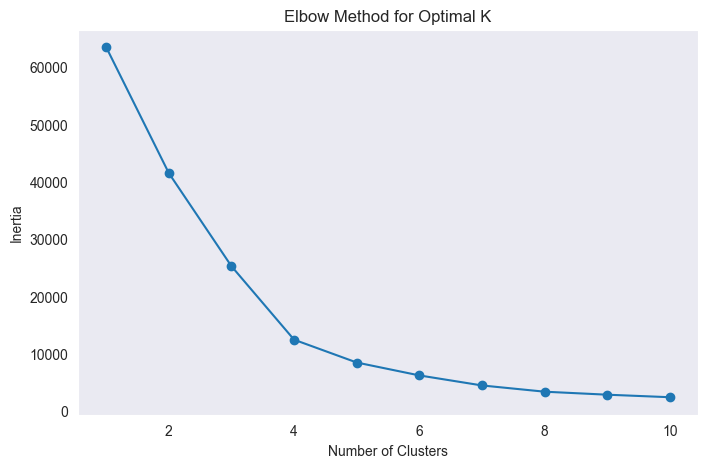

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [10]:
#The Elbow Point is around 4-5 Cluster

## 7. Silhouette Score

In [8]:
silhouette_scores = []
# Define a range of clusters
k_values = range(2, 11)  # Since silhouette score is not defined for k=1

# Calculate silhouette scores
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    silhouette_scores.append(score)
    print(f'Number of Clusters: {k}, Silhouette Score: {score}')


Number of Clusters: 2, Silhouette Score: 0.5262933328935396
Number of Clusters: 3, Silhouette Score: 0.6849269405395211
Number of Clusters: 4, Silhouette Score: 0.7055640249087518
Number of Clusters: 5, Silhouette Score: 0.6442258187631192
Number of Clusters: 6, Silhouette Score: 0.6397274949120204
Number of Clusters: 7, Silhouette Score: 0.6336780848304492
Number of Clusters: 8, Silhouette Score: 0.6074371456800287
Number of Clusters: 9, Silhouette Score: 0.5930302970002789
Number of Clusters: 10, Silhouette Score: 0.5705763597836132


## 8. Visualize Silhouette Score

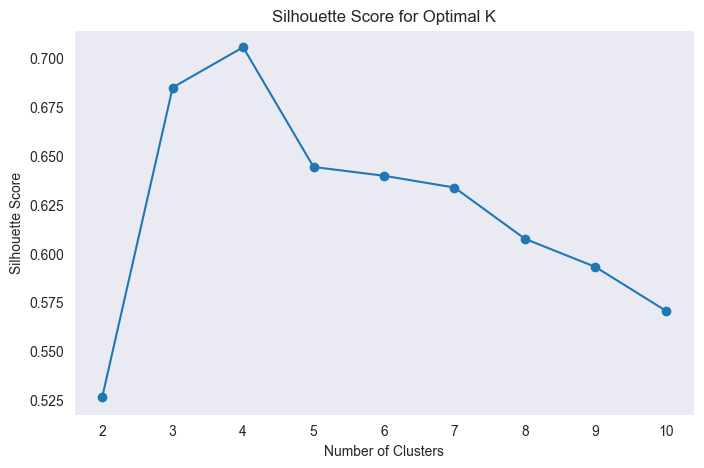

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid()
plt.show()

## 9. Determine best cluster

In [10]:
#Determine best cluster
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f'Silhouette Score Best Cluster: {best_k}')

Silhouette Score Best Cluster: 4


## 10. K-Means Model Training

In [11]:
kmeans_trained = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)  
kmeans_trained.fit(features_scaled)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [15]:
#Save the Model
dump(kmeans_trained, 'activity-preference-model.joblib')

['activity-preference-model.joblib']

## 11. Adding Cluster Label to Data

In [12]:
data['cluster'] = kmeans_trained.labels_

data[['npm', 'nama_kegiatan', 'cluster']].head()

,npm,nama_kegiatan,cluster
0,1931173,Sertifikasi Agile Scrum Fundamentals (ASF) (Qu...,1
1,1931173,The 2nd Conference on Community Engagement Pro...,1
2,1931173,"Seminar Nasional ""Youth`s Impact In Digital Era""",3
3,1931173,Seminar Importance of IT Certifications in Ind...,0
4,1931173,Listening and Reading Official Institutional S...,1


## 12. Analyze most popular Activity Level per cluster

In [13]:
activity_level_counts = data.groupby('cluster')[data.columns[data.columns.str.contains('tingkat_kegiatan_')]].sum()

# Find the most popular activity level for each cluster
most_popular_activity = activity_level_counts.idxmax(axis=1)

# Create a DataFrame for better visualization
result = pd.DataFrame({
    'Cluster': most_popular_activity.index,
    'Most Popular Activity Level': most_popular_activity.values
})

print(result)

   Cluster     Most Popular Activity Level
0        0          tingkat_kegiatan_lokal
1        1  tingkat_kegiatan_international
2        2       tingkat_kegiatan_provinsi
3        3       tingkat_kegiatan_national


## 13. Visualize Clustering Result

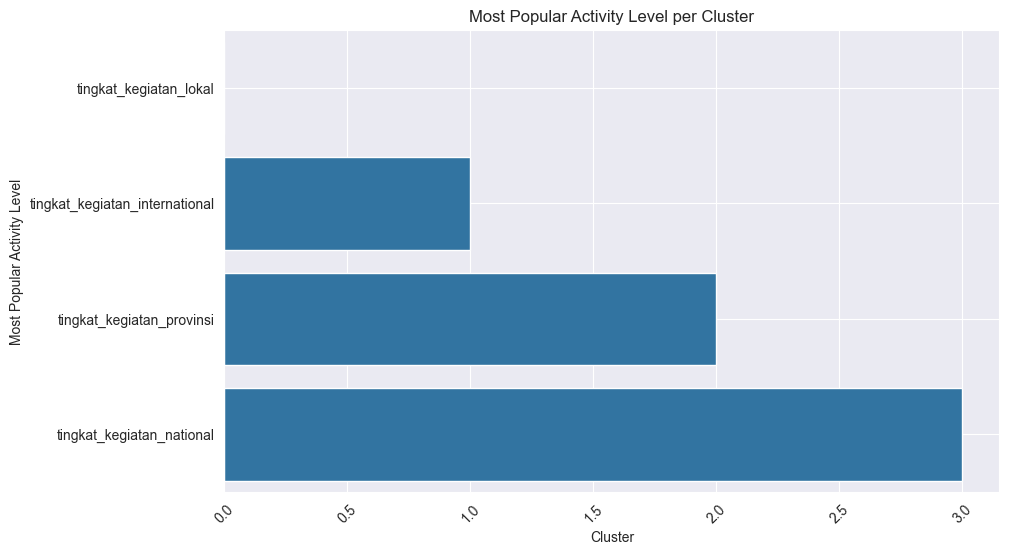

In [14]:
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Cluster', y='Most Popular Activity Level', data=result)

# Add titles and labels
plt.title('Most Popular Activity Level per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Most Popular Activity Level')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y')

# Show the plot
plt.show()

## 14. Use the model

In [15]:
kmeans_model = load('activity-preference-model.joblib')
scaler = load('scaler.joblib')  # Load the scaler used for feature scaling

def get_favorite_tingkat_kegiatan(npm, data):
    # Get data for the student with the given npm
    student_data = data[data['npm'] == npm]

    if student_data.empty:
        return f"Data for {npm} not found."
    
    # Extract the student's name
    nama_mahasiswa = student_data['nama_mahasiswa'].values[0]
    
    # Extract features for prediction
    features = student_data[['ipk_mahasiswa'] + list(student_data.columns[student_data.columns.str.contains('tingkat_kegiatan_')])]

    # Scale the features
    features_scaled = scaler.transform(features)  # Use the fitted scaler from the training phase

    # Predict the cluster for the student
    cluster = kmeans_model.predict(features_scaled)[0]

    # Get all data for students in the same cluster
    cluster_data = data[data['cluster'] == cluster]

    # Find the most common one-hot encoded column for tingkat_kegiatan in the cluster
    tingkat_kegiatan_cols = cluster_data.columns[cluster_data.columns.str.contains('tingkat_kegiatan_')]
    
    # Get the sum of each one-hot encoded column in the cluster
    counts = cluster_data[tingkat_kegiatan_cols].sum()

    # Identify the most common one
    favorite_tingkat_kegiatan_col = counts.idxmax()
    
    # Extract the original category name from the column name
    favorite_tingkat_kegiatan = favorite_tingkat_kegiatan_col.replace('tingkat_kegiatan_', '')

    return f"Tingkat kegiatan kesukaan {nama_mahasiswa} adalah: {favorite_tingkat_kegiatan}."

In [16]:
npm_mahasiswa = 2231152

favorite_activity = get_favorite_tingkat_kegiatan(npm_mahasiswa, data)
print(favorite_activity)

Tingkat kegiatan kesukaan Gary Happydinata adalah: lokal.
